In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
import string
import re
import preprocessor as proc
import nltk

from src.config import CONFIG
from src.preprocessing import SBICDatasetPreprocessing
from src.train_utils import make_tokinzer
from src.utils import PropertyDict
from nltk.corpus import stopwords

nltk.download
nltk.download('wordnet')
nltk.download('stopwords')

2023-10-09 16:16:54.839485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 16:16:55.472220: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package wordnet to /home/matteo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/matteo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Inspection

In [3]:
df = pd.read_csv(CONFIG.dataset.train_data_raw)
df.head()

,whoTarget,intentYN,sexYN,sexReason,offensiveYN,annotatorGender,annotatorMinority,sexPhrase,speakerMinorityYN,WorkerId,HITId,annotatorPolitics,annotatorRace,annotatorAge,post,targetMinority,targetCategory,targetStereotype,dataSource
0,0.0,0.66,0.0,NaN,1.0,woman,NaN,NaN,NaN,-8935932304856669427,363A7XIFV4G2799C5V96YERJA9AVAM,liberal,white,45.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
1,0.0,0.66,0.0,NaN,0.5,man,NaN,NaN,NaN,6347880360297734464,363A7XIFV4G2799C5V96YERJA9AVAM,mod-liberal,white,35.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
2,0.0,0.33,0.0,NaN,0.5,man,NaN,NaN,NaN,-7452610791699819066,363A7XIFV4G2799C5V96YERJA9AVAM,liberal,asian,23.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN,t/davidson
3,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,3JTPR5MTZS6RLS3JBV4IOU0G2X35K5,liberal,white,25.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,all stupid,t/davidson
4,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,3JTPR5MTZS6RLS3JBV4IOU0G2X35K5,liberal,white,25.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,are not people but apes.,t/davidson


In [4]:
df.columns

Index(['whoTarget', 'intentYN', 'sexYN', 'sexReason', 'offensiveYN',
       'annotatorGender', 'annotatorMinority', 'sexPhrase',
       'speakerMinorityYN', 'WorkerId', 'HITId', 'annotatorPolitics',
       'annotatorRace', 'annotatorAge', 'post', 'targetMinority',
       'targetCategory', 'targetStereotype', 'dataSource'],
      dtype='object')

In [5]:
df["sexReason"].unique()

array([nan, 'refers to lots of sexual activity', 'women wanting sex', ...,
       'about masturbating', 'directly references masturbation',
       'man with a small penis'], dtype=object)

In [6]:
df["sexPhrase"].unique()

array([nan, 'hoe shit', 'hoes bent over', ...,
       'I have scoliosis and shoulder higher than the other due to compulsive masturbation',
       'compulsive masturbation',
       'I have scoliosis and shoulder higher than the other due to compulsive masturbation If I had sex that never would have happened.'],
      dtype=object)

In [7]:
print(f"Tolal number of annotations: {len(df)}")
print("\nNumber of NaN values inside columns:")
print(df.isna().sum())

Tolal number of annotations: 112900

Number of NaN values inside columns:
whoTarget             46931
intentYN                  0
sexYN                     0
sexReason            102520
offensiveYN            2017
annotatorGender           1
annotatorMinority     86549
sexPhrase            102507
speakerMinorityYN     67437
WorkerId                  0
HITId                     0
annotatorPolitics         1
annotatorRace             1
annotatorAge              1
post                      0
targetMinority        70406
targetCategory        70406
targetStereotype      71192
dataSource                0
dtype: int64


In [8]:
np.percentile(df['targetMinority'].fillna("").str.len(), 99)


34.0

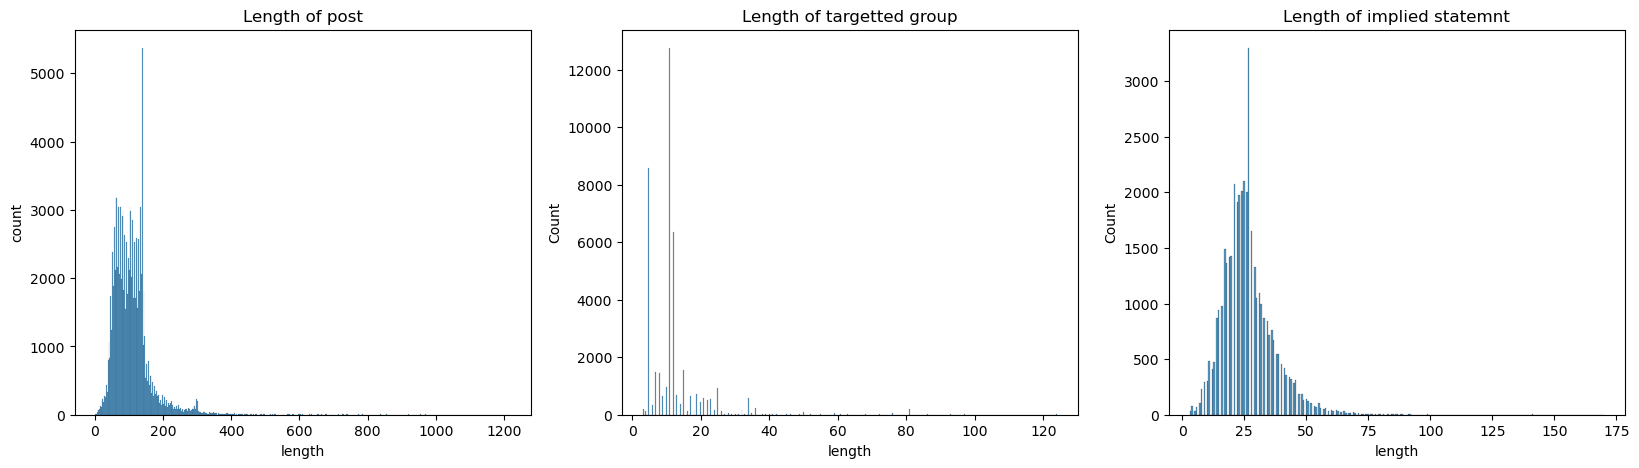

,post_length,group_length,streotype_length
count,112900.000000,112900.000000,112900.000000
mean,109.340425,4.748096,9.820204
std,61.957050,8.707602,14.277202
min,2.000000,0.000000,0.000000
25%,71.000000,0.000000,0.000000
50%,101.000000,0.000000,0.000000
75%,133.000000,11.000000,22.000000
max,1217.000000,124.000000,170.000000


In [9]:
posts_len = df['post'].fillna("").str.len().tolist()
grps_len = df['targetMinority'].fillna("").str.len().tolist()
strps_len = df['targetStereotype'].fillna("").str.len().tolist()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(20, 5))
sns.histplot([len for len in posts_len if len != 0], ax=ax1)
sns.histplot([len for len in grps_len if len != 0], ax=ax2)
sns.histplot([len for len in strps_len if len != 0], ax=ax3)
ax1.set_title("Length of post")
ax2.set_title("Length of targetted group")
ax3.set_title("Length of implied statemnt")
ax1.set_xlabel("length")
ax2.set_xlabel("length")
ax3.set_xlabel("length")
ax1.set_ylabel("count")
plt.show()

tmp = pd.DataFrame(list(zip(posts_len, grps_len, strps_len)), columns=["post_length", "group_length", "streotype_length"])
display(tmp.describe())

In [10]:
config = PropertyDict(
    checkpoint_name="distilgpt2",
    model_name="distilgpt2",
    padding_side="left",
)

tokenizer = make_tokinzer(config)

List of all special token and its token_id:
 - ['<|endoftext|>', '<|sep|>', '<|pad|>', '<|offY|>', '<|offN|>', '<|sexY|>', '<|sexN|>', '<|intY|>', '<|intN|>', '<|grpY|>', '<|grpN|>', '<|ingrpN|>', '<|ingrpY|>']
 - [[50256], [50258], [50257], [50259], [50260], [50261], [50262], [50263], [50264], [50265], [50266], [50267], [50268]]


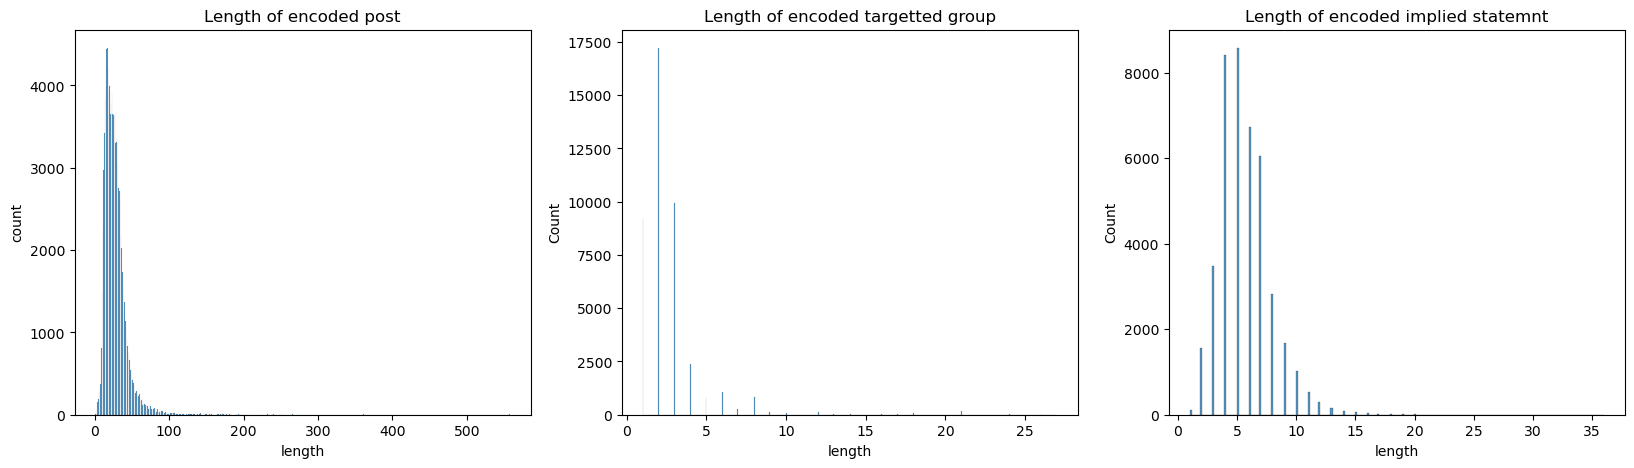

,encoded_post_length,encoded_group_length,encoded_streotype_length
count,112900.000000,112900.000000,112900.000000
mean,27.594198,1.014331,2.096457
std,16.773132,1.964257,3.055493
min,1.000000,0.000000,0.000000
25%,17.000000,0.000000,0.000000
50%,25.000000,0.000000,0.000000
75%,33.000000,2.000000,4.000000
max,558.000000,27.000000,36.000000


In [11]:
enc_posts = tokenizer(df['post'].fillna("").tolist())["input_ids"]
enc_groups = tokenizer(df['targetMinority'].fillna("").tolist())["input_ids"]
enc_stereotypes = tokenizer(df['targetStereotype'].fillna("").tolist())["input_ids"]

len_enc_posts = [len(enc) for enc in enc_posts]
len_enc_groups = [len(enc) for enc in enc_groups]
len_enc_stereotypes = [len(enc) for enc in enc_stereotypes]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(20, 5))
sns.histplot([len for len in len_enc_posts if len != 0], ax=ax1)
sns.histplot([len for len in len_enc_groups if len != 0], ax=ax2)
sns.histplot([len for len in len_enc_stereotypes if len != 0], ax=ax3)
ax1.set_title("Length of encoded post")
ax2.set_title("Length of encoded targetted group")
ax3.set_title("Length of encoded implied statemnt")
ax1.set_xlabel("length")
ax2.set_xlabel("length")
ax3.set_xlabel("length")
ax1.set_ylabel("count")
plt.show()

tmp = pd.DataFrame(list(zip(len_enc_posts, len_enc_groups, len_enc_stereotypes)), columns=["encoded_post_length", "encoded_group_length", "encoded_streotype_length"])
display(tmp.describe())

In the worst case, if we take all these three element considering their respective maximum length, the input would be $558 + 27 + 36 = 621$ tokens long and it's very far from the $1024$ GPT2 input max lenght. At this point, we are sure that no one post will be truncated when it will passed to the model as input.

## Train data Preprocessing

### NaN Preprocessing

In [12]:
textFields = ['targetMinority', 'targetStereotype']
classFields = ['whoTarget', 'intentYN', 'sexYN','offensiveYN']
columns_to_drop=["sexReason", "annotatorGender", "annotatorMinority", "sexPhrase", "WorkerId", "HITId", "annotatorPolitics", "annotatorRace", "annotatorAge", "targetCategory"]

preproc = SBICDatasetPreprocessing(tokenizer, 
                                   textFields=textFields,
                                   classFields=classFields,
                                   )

As first preprocessing, we will remove those data that will not be used during training or inference time. Reorder also the columns to had better comprension of the data

In [13]:
df_red = df.drop(columns=columns_to_drop, axis=1)
cols = ['post', 'offensiveYN', 'intentYN', 'sexYN', 'whoTarget', 'targetMinority', 'targetStereotype', 'speakerMinorityYN', 'dataSource']
df_red = df_red[cols]
df_red = df_red.rename(columns={"whoTarget": "groupTargetYN", "speakerMinorityYN": "inGroupYN", 'targetMinority': 'targetGroup'})
df_red.head()

,post,offensiveYN,intentYN,sexYN,groupTargetYN,targetGroup,targetStereotype,inGroupYN,dataSource
0,RT @_LexC__: I'm convinced that some of y'all ...,1.0,0.66,0.0,0.0,NaN,NaN,NaN,t/davidson
1,RT @_LexC__: I'm convinced that some of y'all ...,0.5,0.66,0.0,0.0,NaN,NaN,NaN,t/davidson
2,RT @_LexC__: I'm convinced that some of y'all ...,0.5,0.33,0.0,0.0,NaN,NaN,NaN,t/davidson
3,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1.0,1.00,0.0,1.0,black folks,all stupid,0.0,t/davidson
4,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1.0,1.00,0.0,1.0,black folks,are not people but apes.,0.0,t/davidson


Recall number of NaN present in the data

In [14]:
display(df_red.isna().sum())

nan_off_ann = df_red["offensiveYN"].isna().sum()
print(f"Number of post that have NaN offensive label: {nan_off_ann} ({nan_off_ann/len(df_red)*100:.1f} %)")

post                    0
offensiveYN          2017
intentYN                0
sexYN                   0
groupTargetYN       46931
targetGroup         70406
targetStereotype    71192
inGroupYN           67437
dataSource              0
dtype: int64

Number of post that have NaN offensive label: 2017 (1.8 %)


As you can see, there are several nan in last columns and this can be due to the fact that if a post isn't offensive, annotator doesn't fill these fields. At the same time, first column should not present any nan. 

Since, the presence of the nan in the offensive colum is very small and it could lead to error during the training, we decide to drop them.

In [15]:
drop_idx = [idx for idx,val in (df_red["offensiveYN"].isna()).items() if val]
df_red = df_red.drop(drop_idx)
display(df_red.isna().sum())

post                    0
offensiveYN             0
intentYN                0
sexYN                   0
groupTargetYN       45023
targetGroup         68392
targetStereotype    69178
inGroupYN           65492
dataSource              0
dtype: int64

Now, move on to the columns *groupTargetYN*. It indicates if a post targets a group or an individual. The presence of so many nan values can be justify to the fact that, if a post was annotated as not offensive, this field should not contains any values. In order to have better understanding od the data, plot some statistics.

In [16]:
nooff_mask = df_red['offensiveYN'] < 0.5
nogrp_mask = df_red["groupTargetYN"].isna()

print(f"Total not offensive annotations: \t{sum(nooff_mask)}")
print(f"Total nan values:\t\t\t{sum(nogrp_mask)}")
print(f"Total nan values with offensive=0:\t{sum(df_red[nogrp_mask]['offensiveYN'] < 0.5)}")
print(f"Total nan values with offensive=1:\t{sum(~df_red[nooff_mask]['groupTargetYN'].isna())}")

Total not offensive annotations: 	46673
Total nan values:			45023
Total nan values with offensive=0:	45023
Total nan values with offensive=1:	1650


All NaN values in *groupTargetYN* are due to the presence of annotation with offensiveness set to zero. At the same time, not all not offensive annotations have set to NaN this column. So, we drop this features.

In [17]:
drop_idx = [idx for idx,val in (~df_red[nooff_mask]['groupTargetYN'].isna()).items() if val]
df_red = df_red.drop(drop_idx)
display(df_red.isna().sum())

post                    0
offensiveYN             0
intentYN                0
sexYN                   0
groupTargetYN       45023
targetGroup         66750
targetStereotype    67536
inGroupYN           65376
dataSource              0
dtype: int64


At this point, we had to check the correctness of the *targetGroup* and *targetStereotype* columns. They should have a NaN values if:
- a post is not considered not offensive
- if the *groupTargetYN* field had a value equal to 0

So, in order to check, we want understand how many annotation break these rules.

In [18]:
nooff_mask = df_red['offensiveYN'] < 0.5
nogrp_mask = df_red["groupTargetYN"] < 0.5
tgtgrp_mask = ~df_red["targetGroup"].isna()

print("Analysis of targetGroup columns")
print(f"Total not nan values if offensive=0:\t{sum(~df_red[nooff_mask]['targetGroup'].isna())}")
print(f"Total not nan values if group=0:\t\t{sum(~df_red[nogrp_mask]['targetGroup'].isna())}")
print()
print("Analysis of targetStereotype columns")
print(f"Total not nan values if offensive=0:\t{sum(~df_red[nooff_mask]['targetStereotype'].isna())}")
print(f"Total not nan values if group=0:\t\t{sum(~df_red[nogrp_mask]['targetStereotype'].isna())}")
print(f"Total nan values if targetted group is set:\t\t{sum(df_red[tgtgrp_mask]['targetStereotype'].isna())}")

Analysis of targetGroup columns
Total not nan values if offensive=0:	3
Total not nan values if group=0:		115

Analysis of targetStereotype columns
Total not nan values if offensive=0:	3
Total not nan values if group=0:		112
Total nan values if targetted group is set:		786


As you can see, there are some annotations that don't follow the rule and as we did previous, we drop it.

In [19]:
drop_idx = [idx for idx,val in (~df_red[nooff_mask]['targetGroup'].isna()).items() if val]
drop_idx2 = [idx for idx,val in (~df_red[nogrp_mask]['targetGroup'].isna()).items() if val]
drop_idx3 = [idx for idx,val in (df_red[tgtgrp_mask]['targetStereotype'].isna()).items() if val]
df_red = df_red.drop(set(drop_idx+drop_idx2+drop_idx3))
display(df_red.isna().sum())

post                    0
offensiveYN             0
intentYN                0
sexYN                   0
groupTargetYN       45020
targetGroup         66750
targetStereotype    66750
inGroupYN           65346
dataSource              0
dtype: int64

Now, since for the columns *inGroupYN* we cannot infer any prior knowledge, we will replace NaN values with some placeholder.

At this point, we had just to check the overall correctness of annotations. We consider wrong an annotation if:
- if a post not offensive, is considered intentionally offensive or it refers to a group
- if an offensive post that not refers to any group have a targetted group and stereotype set to some value

In [20]:
df_red[["groupTargetYN", "inGroupYN"]] = df_red[["groupTargetYN", "inGroupYN"]].fillna(2)
df_red[["targetGroup", "targetStereotype"]] = df_red[["targetGroup", "targetStereotype"]].fillna("")
display(df_red.isna().sum())

post                0
offensiveYN         0
intentYN            0
sexYN               0
groupTargetYN       0
targetGroup         0
targetStereotype    0
inGroupYN           0
dataSource          0
dtype: int64

Binarize classification variable

In [21]:
classFields = ['offensiveYN', 'intentYN', 'sexYN','groupTargetYN', "inGroupYN"]
for field in  classFields:
    df_red[field] = df_red[field].apply(lambda c: int(c>=0.5) if c < 2 else 2)
display(df_red.head())
df_red.to_pickle(CONFIG.dataset.train_data_preproc)

print("Element removed during pre processing:", len(df)-len(df_red))

,post,offensiveYN,intentYN,sexYN,groupTargetYN,targetGroup,targetStereotype,inGroupYN,dataSource
0,RT @_LexC__: I'm convinced that some of y'all ...,1,1,0,0,,,2,t/davidson
1,RT @_LexC__: I'm convinced that some of y'all ...,1,1,0,0,,,2,t/davidson
2,RT @_LexC__: I'm convinced that some of y'all ...,1,0,0,0,,,2,t/davidson
3,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1,1,0,1,black folks,all stupid,0,t/davidson
4,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1,1,0,1,black folks,are not people but apes.,0,t/davidson


Element removed during pre processing: 4568


### Post Preprocessing

In [ ]:
df = pd.read_pickle(CONFIG.dataset.train_data_preproc)
df.head()

,post,offensiveYN,intentYN,sexYN,groupTargetYN,targetGroup,targetStereotype,inGroupYN,dataSource
0,RT @_LexC__: I'm convinced that some of y'all ...,1,1,0,0,,,2,t/davidson
1,RT @_LexC__: I'm convinced that some of y'all ...,1,1,0,0,,,2,t/davidson
2,RT @_LexC__: I'm convinced that some of y'all ...,1,0,0,0,,,2,t/davidson
3,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1,1,0,1,black folks,all stupid,0,t/davidson
4,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1,1,0,1,black folks,are not people but apes.,0,t/davidson


In [ ]:
#HappyEmoticons
emoticons = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3', ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE) 

html_pattern = re.compile(r"&.*?;")

In [ ]:
def clean_tweets(tweet):
    
    stop_words = set(stopwords.words('english'))
    # word_tokens = word_tokenize(tweet)
    #after tweepy preprocessing the colon symbol left remain after      #removing mentions
    tweet = proc.clean(tweet)

    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)

    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    #remove emojis from tweet

    tweet = emoji_pattern.sub(r'', tweet)
    tweet = html_pattern.sub(r'', tweet)

    #filter using NLTK library append it to a string
    # filtered_tweet = [w for w in tweet.split(" ") if not w in stop_words]
    
    return tweet

    # filtered_tweet = []


    # #looping through conditions
    # for w in tweet.split(" "):
    # #check tokens against stop words , emoticons and punctuations
    #     if w not in stop_words and w not in emoticons and w not in string.punctuation:
    #         filtered_tweet.append(w)

    # return ' '.join(filtered_tweet)

In [ ]:
print(df.iloc[0]["post"])
df["post"] = df["post"].apply(lambda x: clean_tweets(x))
print(df.iloc[0]["post"])

RT @_LexC__: I'm convinced that some of y'all bitches get pregnant purposely because "birth control &amp; plan b pills" are effective &#128533;&#128056;&#9749;&#65039;
 I'm convinced that some of y'all bitches get pregnant purposely because "birth control  plan b pills" are effective 


In [ ]:
df = df.drop(columns=["dataSource"], axis=1)
df.to_pickle(CONFIG.dataset.train_data)